In [2]:
%cd src
!conda run -n simple_env python3 -m numpy.f2py -c -m polyomino_simulation polyomino_simulation.f90 --opt='-O3'
%cd ..

/Users/daviderevignas/scientific_projects/scientific_code/polyomini/src
running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "polyomino_simulation" sources
INFO: f2py options: []
INFO: f2py:> /var/folders/n5/f496lkj93z1d5p8bbkfqkhtr0000gn/T/tmpoplufmk2/src.macosx-11.0-arm64-3.9/polyomino_simulationmodule.c
creating /var/folders/n5/f496lkj93z1d5p8bbkfqkhtr0000gn/T/tmpoplufmk2/src.macosx-11.0-arm64-3.9
Reading fortran codes...
	Reading file 'polyomino_simulation.f90' (format:free)
Post-processing...
	Block: polyomino_simulation
			Block: polyomino_simulation
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "polyomino_simulation"...
    Generating possibly empty w

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

import os
from numba import njit
import sys 
module_path = "src"
sys.path.append(module_path)
import polyomino_simulation






In [4]:
omino_1 = np.array([[0,0],[0,1],[0,2],[0,3]],dtype=np.int32)
omino_2 = np.array([[0,0],[0,1],[1,0],[1,1]],dtype=np.int32)
omino_3 = np.array([[0,0],[0,1],[0,2],[1,2]],dtype=np.int32)
omino_4 = np.array([[0,0],[0,1],[0,2],[1,1]],dtype=np.int32)
omino_5 = np.array([[0,0],[0,1],[1,1],[1,2]],dtype=np.int32)

omino_1 = omino_1[..., np.newaxis]  # (4,2,1)
omino_2 = omino_2[..., np.newaxis] 
omino_3 = omino_3[..., np.newaxis]  
omino_4 = omino_4[..., np.newaxis]  
omino_5 = omino_5[..., np.newaxis]  

ominos_sizes= np.array([4,4,4,4,4],dtype=np.int32)
max_omino_size=np.max(ominos_sizes)

omino_shapes = np.concatenate([omino_1, omino_2, omino_3, omino_4,omino_5], axis=2)
n_omino_types = omino_shapes.shape[-1]





In [13]:
box_size = 80
n_ominos_per_shape=np.array([8,6,8,6,6],dtype=np.int32)
n_ominos_per_shape=np.array([50,50,30,30,40],dtype=np.int32)
n_ominos_per_shape=np.array([300,300,200,0,0],dtype=np.int32)
n_ominos_per_shape=np.array([0,0,400,400,0],dtype=np.int32)
n_ominos_per_shape=np.array([100,100,100,100,100],dtype=np.int32)
n_ominos = np.sum(n_ominos_per_shape)

crystal_cell_size_x = 2
crystal_cell_size_y = max_omino_size
crystal_n_cells = (box_size//crystal_cell_size_x)*(box_size//crystal_cell_size_y)

if crystal_n_cells < n_ominos:
    raise ValueError('INCREASE box_size')


crystal_coords=[]
for ix in range(box_size//crystal_cell_size_x):
    for iy in range(box_size//crystal_cell_size_y):
        crystal_coords.append([ix*crystal_cell_size_x+1,iy*crystal_cell_size_y+1])
crystal_coords=np.array(crystal_coords,dtype=np.int32)

crystal_coords_order=np.arange(crystal_n_cells,dtype=np.int32)
np.random.shuffle(crystal_coords_order)
crystal_coords_order=crystal_coords_order[:n_ominos]

initial_positions=crystal_coords[crystal_coords_order]
initial_orientations = np.ones(n_ominos,dtype=np.int32)


In [14]:
# First part: Create vec_omino_types array
i_omino = 0
vec_omino_types = np.zeros(n_ominos, dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    for i_omino_of_type in range(n_ominos_per_shape[i_omino_type - 1]):  # Convert to 0-based indexing
        vec_omino_types[i_omino] = i_omino_type
        i_omino += 1

# Second part: Create rotated shapes array
rot_omino_shapes = np.zeros((max_omino_size, 2, n_omino_types, 4), dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    omino_type_idx = i_omino_type - 1  # Convert to 0-based for array indexing
    
    for i_cell in range(ominos_sizes[omino_type_idx]):  # 0 to ominos_sizes-1
        # Get original coordinates (convert from 1-based to 0-based indexing)
        orig_x = omino_shapes[i_cell, 0, omino_type_idx]
        orig_y = omino_shapes[i_cell, 1, omino_type_idx]
        
        # Rotation 1: 0 degrees clockwise (x,y) -> (x,y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 0] = orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 0] = orig_y
        
        # Rotation 2: 90 degrees clockwise (x,y) -> (-y,x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 1] = -orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 1] = orig_x
        
        # Rotation 3: 180 degrees (x,y) -> (-x,-y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 2] = -orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 2] = -orig_y
        
        # Rotation 4: 270 degrees clockwise (x,y) -> (y,-x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 3] = orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 3] = -orig_x


In [ ]:
n_mc_steps=4000000
n_savings=40
prng_seed=np.random.randint(1,100000)

start_time = time.time()
system_snapshots,history_positions, history_orientations=polyomino_simulation.polyomino_simulation(
    n_mc_steps=n_mc_steps,
    n_savings=n_savings,
    n_omino_types=n_omino_types,
    ominos_sizes=ominos_sizes,
    max_omino_size=max_omino_size,
    omino_shapes=omino_shapes,
    n_ominos_per_shape=n_ominos_per_shape,
    n_ominos=n_ominos,
    initial_positions=initial_positions,
    initial_orientations=initial_orientations,
    box_size=box_size,
    prng_seed=prng_seed,
)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 77.83 seconds


In [ ]:
system_snapshots.sum()/(n_savings*n_ominos)

4.0

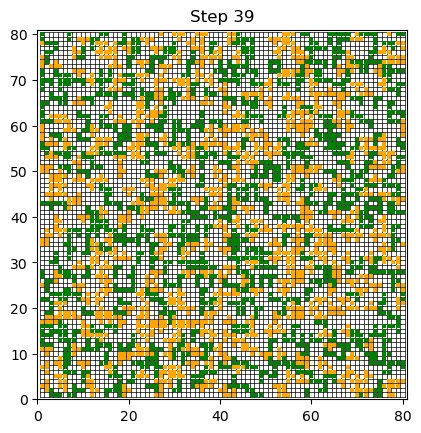

In [ ]:


def create_system_snapshots_with_colors(history_positions, history_orientations, 
                                       vec_omino_types, ominos_sizes, 
                                       rot_omino_shapes, box_size):
    """
    Create system snapshots with polyomino type information for coloring
    """
    n_ominos, _, n_snapshots = history_positions.shape
    
    # Create array to store omino type at each position (0 = empty, 1+ = omino type)
    system_snapshots_colored = np.zeros((box_size, box_size, n_snapshots), dtype=int)
    
    for i_snapshot in range(n_snapshots):
        current_system_state = np.zeros((box_size, box_size), dtype=int)
        
        for i_omino in range(n_ominos):
            i_omino_type = vec_omino_types[i_omino] - 1  # Convert to 0-based indexing
            current_position = history_positions[i_omino, :, i_snapshot]
            current_orientation = history_orientations[i_omino, i_snapshot] - 1  # Convert to 0-based
            
            # Get number of cells for this omino type
            omino_size = ominos_sizes[i_omino_type]
            
            for i_cell in range(omino_size):
                # Calculate cell position with rotation and periodic boundaries
                ix_cell = ((current_position[0] - 1 + 
                           rot_omino_shapes[i_cell, 0, i_omino_type, current_orientation]) 
                          % box_size)
                iy_cell = ((current_position[1] - 1 + 
                           rot_omino_shapes[i_cell, 1, i_omino_type, current_orientation]) 
                          % box_size)
                
                # Store omino type (1-based for visualization)
                current_system_state[int(ix_cell), int(iy_cell)] = i_omino_type + 1
        
        system_snapshots_colored[:, :, i_snapshot] = current_system_state
    
    return system_snapshots_colored

# Create the colored system snapshots
system_snapshots_colored = create_system_snapshots_with_colors(
    history_positions, history_orientations, vec_omino_types, 
    ominos_sizes, rot_omino_shapes, box_size
)

# --- Setup with colors ---
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axisbelow(True)

ax.set_xlim([0, box_size+1])
ax.set_ylim([0, box_size+1])

# Draw grid once (static)
for i in range(box_size + 1):
    ax.plot([i+0.5, i+0.5], [0.5, box_size+0.5], color='black', linewidth=0.5)
    ax.plot([0.5, box_size+0.5], [i+0.5, i+0.5], color='black', linewidth=0.5)

# Define colors for different omino types
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink']

block_size_plot = 3
scatters = []  # keep references for clearing

# --- Update function for animation ---
def update(i_snapshot):
    global scatters
    # remove old markers
    for sc in scatters:
        sc.remove()
    scatters = []

    for ix in range(box_size):
        for iy in range(box_size):
            omino_type = system_snapshots_colored[ix, iy, i_snapshot]
            if omino_type > 0:  # If cell is occupied
                color_idx = (omino_type - 1) % len(colors)  # Cycle through colors
                
                sc = ax.plot(ix+1, iy+1, 
                           marker='s',
                           color=colors[color_idx],
                           markersize=block_size_plot,
                           markeredgewidth=0.0,
                           markeredgecolor='black')
                scatters.extend(sc)  # plot returns a list

    ax.set_title(f'Step {i_snapshot}')
    return scatters

# --- Create animation ---
n_snapshots = system_snapshots_colored.shape[2]  # number of frames
ani = animation.FuncAnimation(fig, update, frames=n_snapshots, blit=False, repeat=True)

# --- Save as GIF ---
path_to_gifs='gifs/'

gif_name='system_'
for n in n_ominos_per_shape:
    gif_name+=f'_{n:}'
gif_name+=f'__bs_{box_size:}'

ani.save(f"{path_to_gifs:}/{gif_name:}.gif", writer="pillow", fps=5)
plt.show()

In [ ]:

gif_name

'system__0_0_400_400_0__bs_80'